# Policy Based Methods

Until now, almost all the methods have been **value-based methods**, they learned the values of actions and then selected actions based on their estimated values. Their policies would not even exist without the value function estimates. 

Now, we consider a different approach directly based on policy. They focus on directly optimizing the metric we care most about in reinforcement learning (the expected reward from acting in an environment), and because of this have an elegant formulation that looks very similar to supervised machine learning, and has stability benefits over approaches like Q-learning, which indirectly learn a policy, and can suffer from too much approximation So, **Policy-based methods** learn directly a parameterized policy ([Sutton et al., **"Policy Gradient Methods for Reinforcement Learning with Function Approximation"**, NIPS, 2000](https://papers.nips.cc/paper_files/paper/1999/hash/464d828b85b0bed98e80ade0a5c43b0f-Abstract.html)) that can select actions **without consulting a value function**. We use the notation:

$\displaystyle \pi_\theta(a|s,\theta)$

in order to highlight that the policy is parameterized by theta. In policy-based methods, the objective is to maximize the performance of the parameterized policy based on the gradient of some scalar performance measure J with respect to the policy parameter:

$\displaystyle \theta_{t+1} = \theta_t + \alpha \nabla J(\theta_t)$

The policy can be parameterized in any way, as long as it is differentiable with respect to its parameters. In practice, **to ensure exploration** we generally require that the policy never becomes deterministic. As an example, we can parameterize the policy as a softmax distribution over the action preferences:

$\displaystyle \pi_\theta(a|s, \theta) = \frac{e^{h(s,a,\theta)}}{\sum_{b} e^{h(s,b, \theta)}}$

where h is the preference function for actions in states, which can be can be parameterized arbitrarily. For example, h might be computed by an neural network, where the parameter is the vector of all the connection weights of the network, or it could simply be a linear function.

About the performance measure, it is rather natural to define it as the **expected total discounted reward from the initial state**, which is the same thing as the **expected state-value function**. 

$\displaystyle J(\theta) = E_{s_0 \sim p_0 } [v_{\pi_{\theta}}(s_0)] $

In order to have a loss function, we can use the negative of the performance measure as the objective function.

The main advantage is we can now learn **stochastic policies**, with better performance under **partially observable environments**. The intuition is that because we can learn arbitrary probabilities of actions, the agent is less dependent on the Markov assumption. For example, if the agent can’t distinguish a handful of states from their emitted observations, the best strategy is often to act randomly with specific probabilities:

<img src="./images/stochastic-policies.png" width="800">

Interestingly, with stochastic policies, **exploration can be embedded in the learned function**.

Moreover, learning stochastic policies could be **more straightforward for function approximation**. Sometimes value functions are **too much informative** for what’s truly needed. It could be that calculating the exact value of a state or state-action pair is complicated or unnecessary:

<img src="./images/learning-policies-vs-value-functions.png" width="800">


Finally, value-based methods are **prone to oscillations and even divergence**: tiny changes in value-function space may imply significant changes in action space. A significant difference in actions can create entirely unusual new trajectories, and therefore create instabilities. In policy-based methods, we instead follow the gradient with respect to stochastic policies, which only progressively and smoothly changes the actions. Therefore, policy-based methods often have **better convergence properties**.

How we can learn a policy that optimizes the value function directly, without learning a value function? We know what we want to find the gradient with respect to that performance metric defined before:

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta E_{s_0 \sim p_0 } [v_{\pi_{\theta}}(s_0)] $

To simplify notation, let’s use $\tau$ as a variable representing a trajectory:

$\displaystyle \tau = S_0, A_0, R_1, S_1,..., S_{T-1}, A_{T-1}, R_T, S_T $

This way we can abuse notation and use the $G$ function to obtain the return of the trajectory:

$\displaystyle G(\tau) = R_1 + \gamma R_2 + ... + \gamma^{T-1}R_T $

We can also get the **probability of a trajectory** as the probability of the initial states, then the action, then the transition, and so on until we have the product of all the probabilities that make the trajectory likely:

$\displaystyle p(\tau|\pi_\theta) = p_0(S_0) \pi_\theta(A_0|S_0) P(S_1,R_1|S_0,A_0)...P(S_T,R_T|S_{T-1},A_{T-1}) $

Using this notation, we can rewrite the objective as:

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta E_{s_0 \sim p_0 } [v_{\pi_{\theta}}(s_0)] = \nabla_\theta E_{\tau \sim \pi_\theta } \left[ G(\tau) \right] $

Now, we can apply a method called **score function gradient estimator** for estimating the gradient of expectation that uses a trick called **likelihood ratio**. The idea is to rewrite the gradient of the expectation as the expectation of the gradient:

$\displaystyle \nabla_\theta E_x \left[f(x) \right] = E_x \left[f(x) \nabla_\theta \log  p(x|\theta))\right] $

We can derive this results as follows:

$\displaystyle \nabla_\theta E_x \left[f(x) \right] = \nabla_\theta \sum\limits_{x}{p(x)f(x)} = \sum\limits_{x}{\nabla_\theta p(x)f(x)} = \sum\limits_{x}{f(x) p(x)\frac{\nabla_\theta p(x)}{p(x)} =} \\
= \sum\limits_{x}f(x){p(x)\nabla_\theta \log p(x)} = E_x \left[f(x)\nabla_\theta \log p(x)\right]$

With that identity, we can substitute values and get this: 

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta E_{\tau \sim \pi_\theta} \left[G(\tau) \right] = E_{\tau \sim \pi_\theta} \left[G(\tau) \nabla_\theta \log  p(\tau|\pi_\theta))\right] = $

Notice the dependence on the probability of the trajectory, however if we substitute it expression, turn the logarithm of a product in the sum of the logarithms, and differentiate with respect to theta, all dependence on the transition function are dropped:

$\displaystyle = E_{\tau \sim \pi_\theta} \left[\sum\limits_{t=0}^{T}{G(\tau) \nabla_\theta \log \pi_\theta(A_t|S_t)}  \right] $

We have a way to compute the policy gradient without knowing anything about the environment’s transition function: we first collect a full trajectory $\tau$ and calculate the full discounted return $G(\tau)$ and then we use that to weight the log probabilities of every action taken in that trajectory: $A_t, A_{t+1},..., A_{T–1}$. 

However, it is better to use only the **causal reward** that come after each action, because we know we can’t go back in time and current actions cannot be responsible for past reward. 

<img src="./images/g_tau_causal.png" width="800">

For each step in the trajectory, we calculate the return just from that step and use that value as the score to weight the log probability of the action taken at that time step:

$\displaystyle \nabla_\theta J(\theta) = E_{\tau \sim \pi_\theta} \left[\sum\limits_{t=0}^{T}{G_t({\tau})\nabla_\theta \log \pi_\theta(A_t|S_t)}  \right] $


## REINFORCE 

The REINFORCE algorith ([R.J. Williams, **"Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning"**, Machine Learning (1992)](https://link.springer.com/article/10.1007/BF00992696)) implements the idea estimating the gradient using the full Monte Carlo returns using a neural network to represent the policy.

First of all we implement the parametric policy as a neural network that takes the state as input and outputs a probability distribution over the actions:

In [1]:
import torch

class PolicyApproximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyApproximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))
        
        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        preferences = self.output_layer(x)

        return preferences
    
    def select_action(self, state):

        # get the preferences over actions
        preferences = self.forward(state)

        # sample the action from the probability distribution
        dist = torch.distributions.Categorical(logits=preferences)
        action = dist.sample()

        # calculate the log probability of the action, it is needed for the loss
        logpa = dist.log_prob(action).unsqueeze(-1)

        return action.item(), logpa
    
    def select_greedy_action(self, state):
        
        # we select the action with the highest preference
        preferences = self.forward(state)
        action = np.argmax(preferences.detach().numpy())
        
        return action
    

We write the optimization method in order to calculate the loss and make a step of gradient descent. The loss is calculated as the log probability of the actions selected weighted by the returns obtained after that action was selected. 

In [2]:
def optimize(model, rewards, logpas, optimizer, gamma):
        
    T = len(rewards)
    
    # calculate the discounts (as with all Monte Carlo methods)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    
    # calculate the sum of discounted returns for all time steps
    # notice this is the returns for every time step in the episode,
    # from the initial state at time step 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # remove the extra elements and format the variables as expected
    returns = torch.FloatTensor(returns)
    
    # prepare the log probabilities of the actions taken
    logpas = torch.cat(logpas)

    # calculate the policy loss
    loss = -(returns * logpas).mean()
    
    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

This time we don't need to create method to implement a epsilon-greedy or greedy strategy, because we can use directly the output of the neural network as a probability distribution over the actions. In the evaluate method instead of selecting only in a greedy way, **we can also sample from the learned stochastic policy**. The correct thing to do here depends on the environment, but sampling is the safe bet.

In [3]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = approximator.select_greedy_action(state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

Finally, we can write the complete algorithm, where we collect a full trajectory and then perform an optimization step:

In [4]:
import time
import numpy as np
import random
from itertools import count

import gymnasium

def reinforce(env_name, seed, gamma, max_time, max_episodes, max_score, episodes_window):
    
    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the policy model
    policy_model = PolicyApproximator(state_size, action_size)
    
    # create the optimizer
    optimizer = torch.optim.RMSprop(policy_model.parameters(), lr=0.0001)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []  

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
    
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # interact with the environment until the episode is done
        logpas = []
        rewards = []

        for step in count():
            
            # select the action using the policy
            action, logpa = policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # save the log probability and the reward
            logpas.append(logpa)
            rewards.append(reward)

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done: 
                break
        
        # then, run one optimization step
        optimize(policy_model, rewards, logpas, optimizer, gamma)

        # evaluate the learned policy after the episode
        score = evaluate(policy_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  

        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
    
    return policy_model, score, results

The REINFORCE algorithm **works well in simple problems**, and it has convergence guarantees. But because it uses the full Monte Carlo returns for calculating the gradient, **its variance is a problem**. The accumulation of random events along a trajectory (including the initial state) and the randomness associated with the stochastic policy is compounded inside the return, making it a high-variance signal that's challenging to interpret. We can run REINFORCE in the cart-pole environment so that we can easily compare it and the DQN value-based method. 

In [5]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1')

In [6]:
def run_experiment(env_name, algorithm, gamma, seeds, 
                   max_time, max_episodes, max_score, episodes_window):

    # variables to collect results
    results = []
    best_agent = None
    best_eval_score = float('-inf')
    
    for seed in seeds:
        # create the agent
        agent, score, result = algorithm(env_name, seed, gamma, 
                                         max_time, max_episodes, max_score, episodes_window)

        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent
        
    return results, best_agent, best_eval_score

In [7]:
reinforce_results, reinforce_agent, reinforce_score = run_experiment(
env_name = 'CartPole-v1',
algorithm = reinforce, 
seeds = (15, 39, 12, 45, 65),
gamma = 0.99,
max_episodes = 1500,
max_time = 60*3,
max_score = 450,
episodes_window = 50)

episode 0965, steps 081258, average score 453.5  --> reached_max_score 
episode 1389, steps 176151, average score 452.4  --> reached_max_score 
episode 1500, steps 155446, average score 395.4  --> reached_max_episodes 
episode 1500, steps 080451, average score 234.5  --> reached_max_episodes 
episode 1500, steps 138364, average score 382.5  --> reached_max_episodes 


We can load the results of DQN in order to compare the performances of the two algorithms:

In [8]:
dqn_results = np.load('dqn_results.npy')

As for value-based algorithms, we can plot the performance of the algorithm over episodes:   

In [9]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

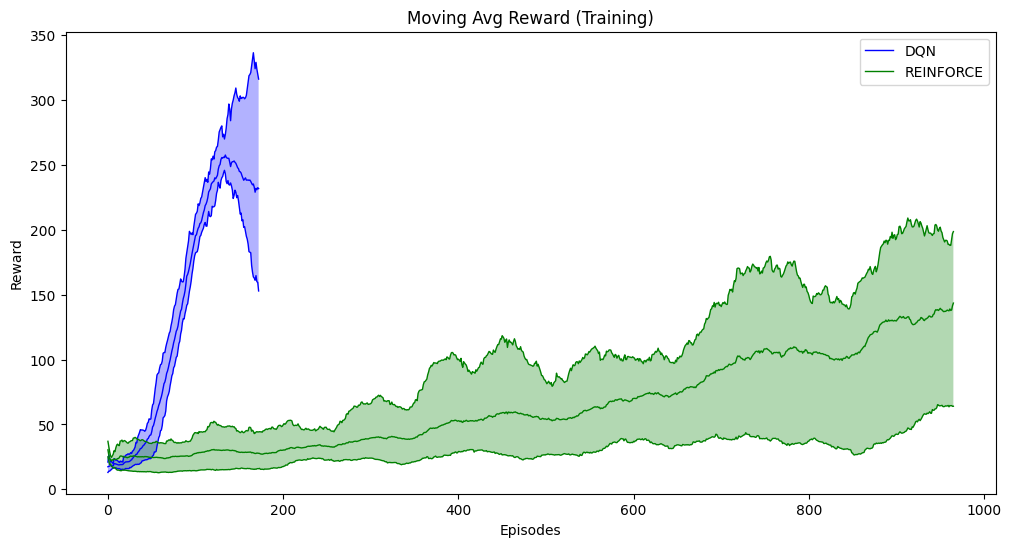

In [10]:
show_result('avg_training_reward','DQN', dqn_results, 'REINFORCE', reinforce_results) 

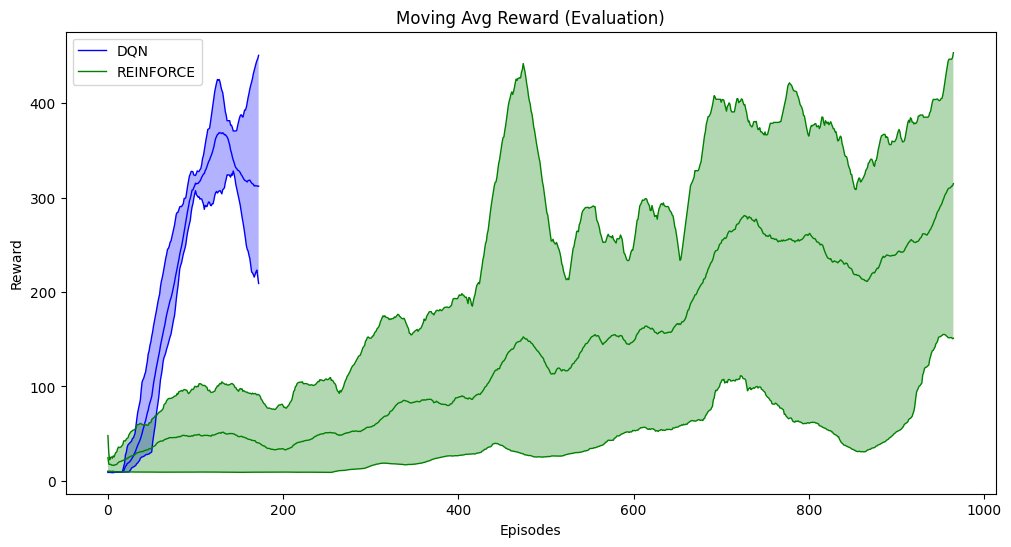

In [11]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'REINFORCE', reinforce_results) 

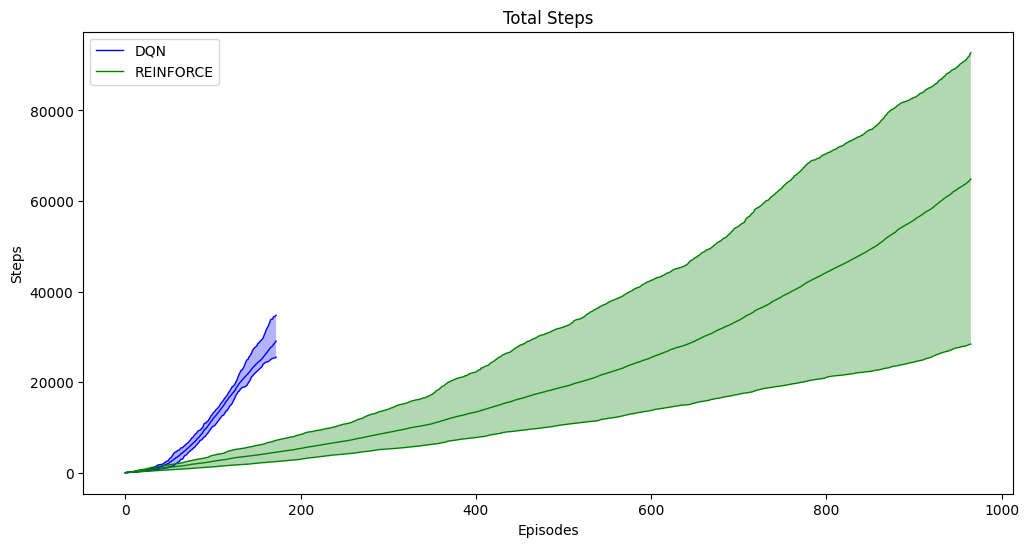

In [12]:
show_result('total_steps','DQN', dqn_results, 'REINFORCE', reinforce_results) 

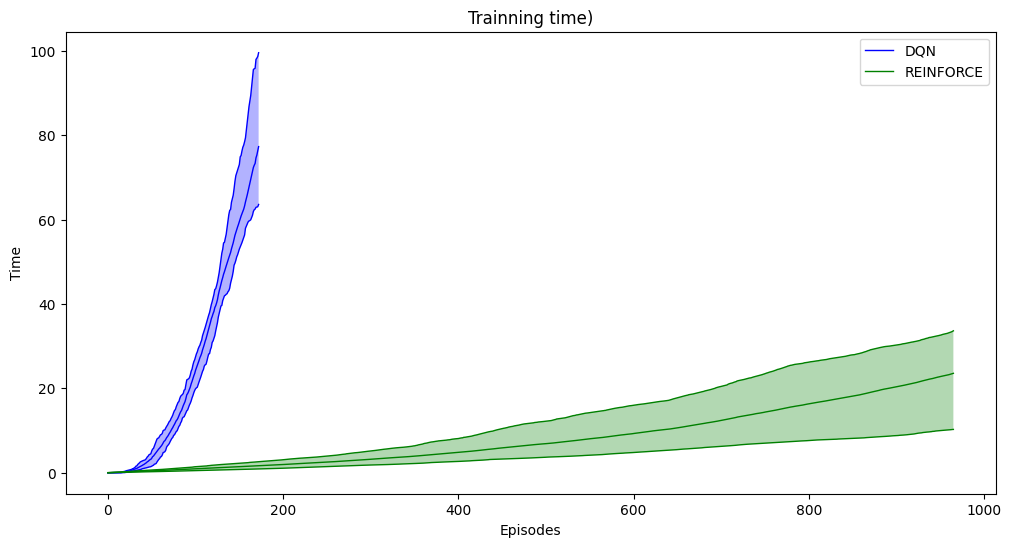

In [13]:
show_result('training_time','DQN', dqn_results, 'REINFORCE', reinforce_results) 

REINFORCE alone is too inefficient to be a practical algorithm. However, in terms of training time, we can see how it uses few resources.

## Vanilla Policy Gradient (VPG)

The key idea underlying policy gradient is to push up the probabilities of actions that lead to higher return, and push down the probabilities of actions that lead to lower return, until we arrive at the optimal policy. However, using a (noisy) Monte Carlo estimate of the return introduces high variance in the policy gradient estimate, which can make learning slow or even diverge. Imagine an environment (such as the cart-pole) in which all rewards are positive, in order to accurately separate good actions from the best actions, we need a lot of data. 

It would be handy if we could use something that allows us to **differentiate the values of actions in the same state**, we can exploit the definition of the **action-advantage function**:

$\displaystyle a_\pi(s,a) = q_\pi(s,a) - v_\pi(s) $

we can say that the advantage function is approximately the following:

$\displaystyle A(S_t,A_t) = R_t + \gamma R_{t+1} + ... + \gamma^{T-1} R_T - v_\pi(S_t) $

An estimate of it is the return minus the estimated expected return from that state:

$\displaystyle A(S_t,A_t) = G_t - V(S_t) $

Using the advantage somewhat **centers scores around zero**. Better-than-average actions have a positive score (increasing probabilities), worse-than-average have a negative score (decreasing probabilities).

We need two neural networks, one for learning the policy as before and the other for learning a state-value function: 

<img src="./images/policy-and-value-network.png" width="800">

The loss for the value function is simple, the mean squared Monte Carlo error:

$\displaystyle L_v(\phi)=\frac{1}{N}\sum\limits_{n=0}^{N}{\left[\left(G_t-V(S_t;\phi)\right)^2\right]} $

and the loss of the policy is the estimated advantage weighted by the log probability of the action taken:

$\displaystyle L_\pi(\theta)=-\frac{1}{N}\sum\limits_{n=0}^{N}{\left[\left(G_t-V(S_t;\phi)\right) \log \pi(A_t|S_t;\theta))\right]} $

However, another essential improvement is to add an **entropy term** to to the loss function. We can interpret entropy in many different ways, from the amount of information one can gain by sampling from a distribution to the number of ways one can order a set. In this context, we can think of entropy in a straightforward way. A uniform distribution, which has evenly distributed samples, has high entropy. If we have two samples, both with a 50% chance, then the entropy is the highest it can be for a two-sample set, conversely, if we have two samples, one with 100% chance, then the entropy is the lowest. The way to use entropy in policy-gradient methods is to add the negative weighted entropy to the loss function **to encourage having evenly distributed actions**. That way, a policy with evenly distributed actions, which yields the highest entropy, contributes to minimizing the loss. On the other hand, converging to a single action, which means entropy is zero, doesn’t reduce the loss. In that case, the agent had better converge to the optimal action:

$\displaystyle L_\pi(\theta)=-\frac{1}{N}\sum\limits_{n=0}^{N}{\left[\left(G_t-V(S_t;\phi)\right) \log \pi(A_t|S_t;\theta) + \beta H(\pi(S_t;\theta))\right]} $

This algorithm is called **Vanilla policy gradient**.

We need a new neural network to approximate the state-value function:

In [14]:
class ValueApproximator(torch.nn.Module):
    def __init__(self, state_size):
        super(ValueApproximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))
        
        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, 1)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        value = self.output_layer(x)

        return value

We need also to the select_action method of the first network (the policy network) in order to calculate also the entropy term:

In [15]:
def select_action(self, state):

    # get the preferences over actions
    preferences = self.forward(state)

    # sample the action from the probability distribution
    dist = torch.distributions.Categorical(logits=preferences)
    action = dist.sample()

    # calculate the log probability of the actions, it is needed for the loss
    logpa = dist.log_prob(action).unsqueeze(-1)

    # calculate the entropy
    entropy = dist.entropy().unsqueeze(-1)

    return action.item(), logpa, entropy

PolicyApproximator.select_action = select_action

The optimize method is different from the previous one, because we have two neural networks to optimize:  

In [27]:
def optimize(policy_model, value_model, rewards, logpas, values, entropies, policy_optimizer, value_optimizer, gamma):
    
    T = len(rewards)
    
    # calculate all discounts (as with all Monte Carlo methods)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)

    # calculate the sum of discounted returns for all time steps
    # notice this is the returns for every time step in the episode,
    # from the initial state at time step 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # remove the extra elements and format the variables as expected
    returns = torch.FloatTensor(returns)
    
    # prepare the log probabilities, the entropies and tge values
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies) 
    values = torch.cat(values)

    # calculate the value error
    value_error = returns - values
 
    # calculate the policy loss
    beta = 0.001
    policy_loss_logpas = -(value_error.detach() * logpas).mean()
    policy_loss_entropies = -entropies.mean()
    policy_loss = policy_loss_logpas + beta * policy_loss_entropies

    # calculate the value loss
    value_loss = (returns - values).pow(2).mean()
        
    # optimize the policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    # optimize the value-function network
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

Finally, we can write the complete algorithm, similar to REINFORCE, but with the addition of the value network and the entropy term:

In [46]:
def vpg(env_name, seed, gamma, max_time, max_episodes, max_score, episodes_window):

    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the policy model and its optimizer
    policy_model = PolicyApproximator(state_size, action_size)
    policy_optimizer = torch.optim.RMSprop(policy_model.parameters(), lr=0.0005)

    # create the value model and its optimizer
    value_model = ValueApproximator(state_size)
    value_optimizer = torch.optim.RMSprop(value_model.parameters(), lr=0.0005)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = [] 

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
        
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # interact with the environment until the episode is done
        logpas = []
        rewards = []
        entropies = []
        values = []
        
        for step in count():
    
            # select the action using the policy
            action, logpa, entropy = policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated
    
            # save the log probability, entropy, reward and value
            logpas.append(logpa)
            entropies.append(entropy)
            rewards.append(reward)
            values.append(value_model(state))

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done: 
                break

        # then, run one optimization step
        optimize(policy_model, value_model, rewards, logpas, values, entropies, policy_optimizer, value_optimizer, gamma)

        # evaluate the learned policy after the episode
        score = evaluate(policy_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  

        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
    
    return policy_model, score, results

We can try the algorithm in the cartpole environment:

In [47]:
vpg_results, vpg_agent, vpg_score = run_experiment(
env_name = 'CartPole-v1',
algorithm = vpg, 
seeds = (15, 39, 12, 45, 65),
gamma = 0.99,
max_episodes = 1500,
max_time = 60*3,
max_score = 450,
episodes_window = 50)

episode 0234, steps 047455, average score 452.5  --> reached_max_score 
episode 0208, steps 047350, average score 452.1  --> reached_max_score 
episode 0208, steps 043332, average score 452.2  --> reached_max_score 
episode 0182, steps 030947, average score 450.7  --> reached_max_score 
episode 0213, steps 041614, average score 451.3  --> reached_max_score 


We can compare VPG with REINFORCE, Notice how VPG is more sample efficient, instead REINFORCE is too inefficient to be a practical algorithm.

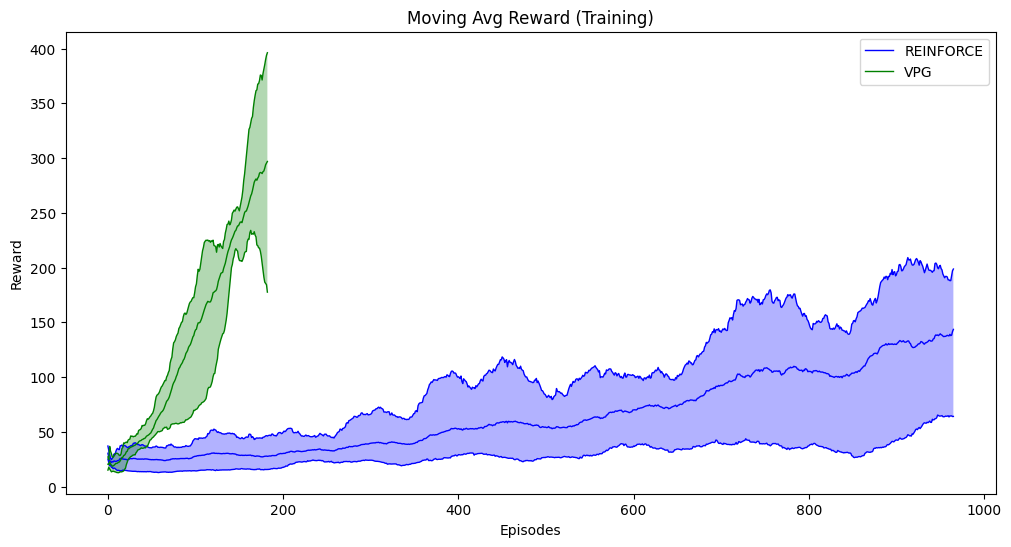

In [48]:
show_result('avg_training_reward','REINFORCE', reinforce_results, 'VPG', vpg_results) 

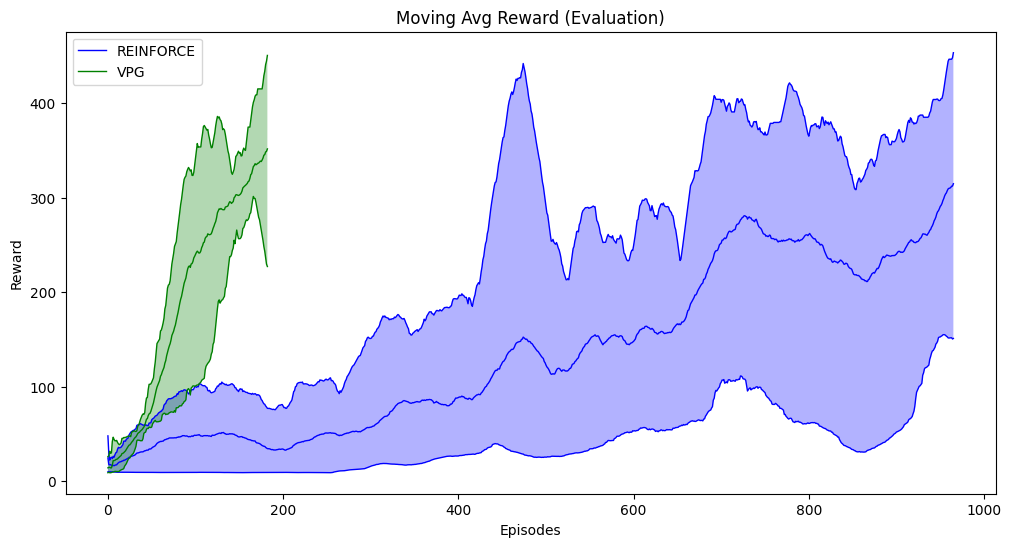

In [49]:
show_result('avg_evaluation_reward','REINFORCE', reinforce_results, 'VPG', vpg_results) 

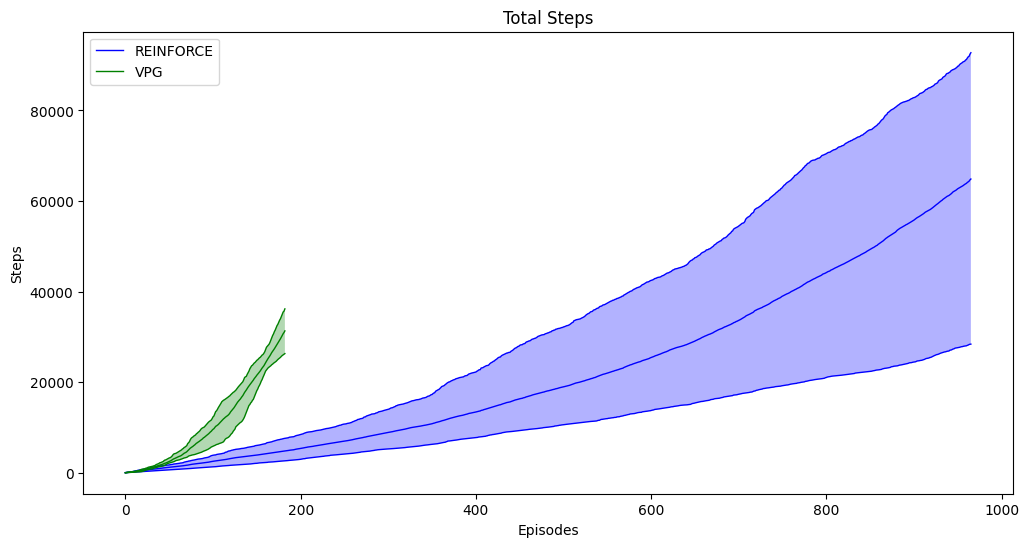

In [50]:
show_result('total_steps','REINFORCE', reinforce_results, 'VPG', vpg_results) 

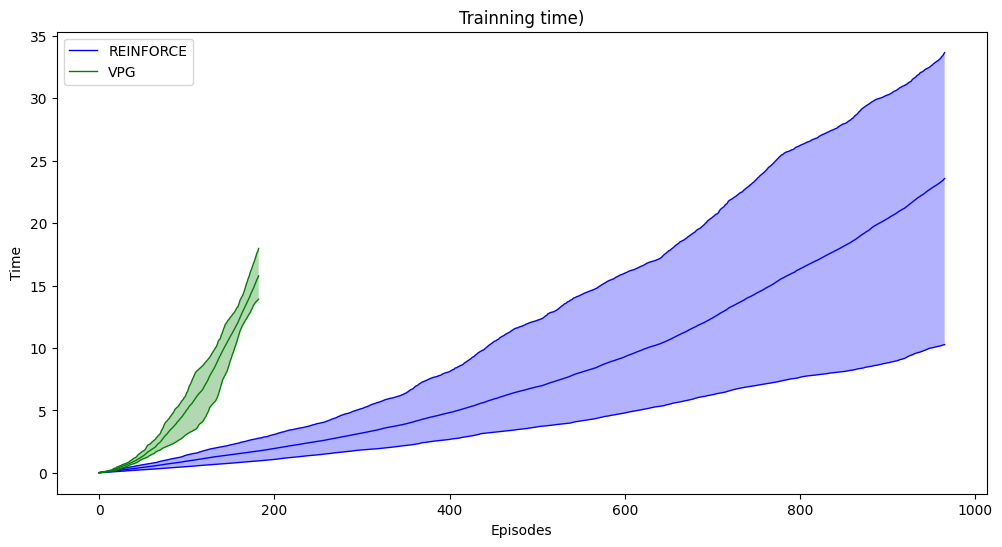

In [51]:
show_result('training_time','REINFORCE', reinforce_results, 'VPG', vpg_results) 

VPG is a pretty robust method for simple problems; it is, for the most part, unbiased because it uses an unbiased target for learning both the policy and value function. That is, it uses Monte Carlo returns, which are complete actual returns experienced directly in the environment, without any bootstrapping. The only bias in the entire algorithm is because we use function approximation, which is inherently biased.